In [1]:
!pip install pretrainedmodels

     |████████████████████████████████| 58 kB 1.8 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=b94c4892e4d597e2231e48b335094bf972af8ed8258db72bc0101dc1f5cd4520
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
import random

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
catalog_eng= pd.read_csv("/kaggle/input/textphase1/data/catalog_english_taxonomy.tsv",sep="\t")

In [4]:
print(catalog_eng.shape)
print(catalog_eng['Prdtypecode'].nunique(),catalog_eng['Top level category'].nunique())


(27, 2)
27 4


In [5]:
catalog_eng.head()

,Prdtypecode,Top level category
0,1280,Child
1,1281,Child
2,1920,Household
3,1160,Entertainment
4,10,Books


In [6]:
catalog_eng['Top level category'].value_counts()


Household        8
Entertainment    8
Child            6
Books            5
Name: Top level category, dtype: int64

In [7]:
X_train= pd.read_csv("/kaggle/input/textphase1/data/X_train.tsv",sep="\t")
Y_train= pd.read_csv("/kaggle/input/textphase1/data/Y_train.tsv",sep="\t")
X_test=pd.read_csv("/kaggle/input/textphase1/data/x_test_task1_phase1.tsv",sep="\t")

In [8]:
X_train.head(2)

,Integer_id,Title,Description,Image_id,Product_id
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,1263597046,3804725264
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,1008141237,436067568


In [9]:
X_test.head(2)

,Integer_id,Title,Description,Image_id,Product_id
0,0,Jeep Police - Gevarm-Gevarm,NaN,1193217616,3136702026
1,1,Court Joyeux Noël En Peluche Taie Sofa Set Pad...,Joyeux Noël en peluche court Taie Sofa Set Pad...,1323615566,4231863665


In [10]:
Y_train.head(2)


,Integer_id,Image_id,Product_id,Prdtypecode
0,0,1263597046,3804725264,10
1,1,1008141237,436067568,2280


In [11]:
dict_code_to_id = {}
dict_id_to_code={}
list_tags = list(Y_train['Prdtypecode'].unique())

for i,tag in enumerate(list_tags):
    dict_code_to_id[tag] = i 
    dict_id_to_code[i]=tag

In [12]:
Y_train['labels']=Y_train['Prdtypecode'].map(dict_code_to_id)

In [13]:
Y_train.head(2)

,Integer_id,Image_id,Product_id,Prdtypecode,labels
0,0,1263597046,3804725264,10,0
1,1,1008141237,436067568,2280,1


In [14]:
train=pd.merge(left=X_train,right=Y_train,
               how='left',left_on=['Integer_id','Image_id','Product_id'],
               right_on=['Integer_id','Image_id','Product_id'])

In [15]:
prod_map=pd.Series(catalog_eng['Top level category'].values,index=catalog_eng['Prdtypecode']).to_dict()

In [16]:
len(prod_map)

27

In [17]:
train.head(2)

,Integer_id,Title,Description,Image_id,Product_id,Prdtypecode,labels
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,1263597046,3804725264,10,0
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,1008141237,436067568,2280,1


In [18]:
train['product']=train['Prdtypecode'].map(prod_map)

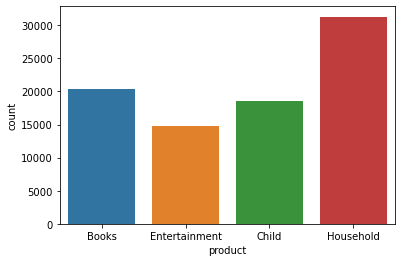

In [19]:
sns.countplot(x='product', data=train)
# train['product'].value_counts()

In [20]:
# sns.countplot(x='Prdtypecode', data=train)
train['Prdtypecode'].value_counts()

2583    10209
1560     5073
1300     5045
2060     4993
2522     4989
1280     4870
2403     4774
2280     4760
1920     4303
1160     3953
1320     3241
10       3116
2705     2761
1140     2671
2582     2589
40       2508
2585     2496
1302     2491
1281     2070
50       1681
2462     1421
2905      872
60        832
2220      824
1301      807
1940      803
1180      764
Name: Prdtypecode, dtype: int64

In [21]:
train_img = train[['Image_id','Product_id','labels','product']]

In [22]:
X_test.head(2)

,Integer_id,Title,Description,Image_id,Product_id
0,0,Jeep Police - Gevarm-Gevarm,NaN,1193217616,3136702026
1,1,Court Joyeux Noël En Peluche Taie Sofa Set Pad...,Joyeux Noël en peluche court Taie Sofa Set Pad...,1323615566,4231863665


In [23]:
#image_Image_id_product_Product_id.jpg
train_img.head(2)

,Image_id,Product_id,labels,product
0,1263597046,3804725264,0,Books
1,1008141237,436067568,1,Books


In [24]:
train_img['Image_id'].iloc[0]

1263597046

In [25]:
def get_img_path(img_id,prd_id,path):
    
    pattern = 'image'+'_'+str(img_id)+'_'+'product'+'_'+str(prd_id)+'.jpg'
    return path + pattern
    

In [26]:
train_img['image_path']=train_img.progress_apply(lambda x: get_img_path(x['Image_id'],x['Product_id'],
                                                                path = '/kaggle/input/imagetrain/image_training/'),axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
X_test['image_path']=X_test.progress_apply(lambda x: get_img_path(x['Image_id'],x['Product_id'],
                                                    path='/kaggle/input/imagetest/image_test/image_test_task1_phase1/'),axis=1)

In [28]:
list_labs = list(train_img['labels'].unique())

In [29]:
train_img.isna().sum()

Image_id      0
Product_id    0
labels        0
product       0
image_path    0
dtype: int64

In [30]:
train_df, val_df, _, _ = train_test_split(train_img, train_img['labels'],random_state=2020, test_size = 0.1, stratify=train_img['labels'])

##### Creating the folder structure

In [31]:
# if not os.path.exists('/kaggle/working/train'):
#     os.mkdir('/kaggle/working/train')
# if not os.path.exists('/kaggle/working/val'):
#     os.mkdir('/kaggle/working/val')


In [32]:
# for uid in list_labs:
#     dirpath1 = os.path.join('/kaggle/working/train/', str(uid))
#     dirpath2 = os.path.join('/kaggle/working/val/', str(uid))
#     #create
#     if not os.path.exists(dirpath1):
#         os.mkdir(dirpath1)
#     if not os.path.exists(dirpath2):
#         os.mkdir(dirpath2)

In [33]:
train_df.head(2)

,Image_id,Product_id,labels,product,image_path
67920,859038125,93889471,1,Books,/kaggle/input/imagetrain/image_training/image_...
35718,1136967867,2336089291,9,Household,/kaggle/input/imagetrain/image_training/image_...


#### Putting the images in the respective folder_structure

#### Transfer Learning with PyTorch

In [34]:
!pip install torchsummary

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
import os
import copy
from torchsummary import summary
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.0
Torchvision Version:  0.6.0a0+82fd1c8


In [36]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = len(dict_code_to_id)

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
# feature_extract = True

#### Data Augmentation


The transform RandomResizedCrop crops the input image by a random size(within a scale range of 0.8 to 1.0 of the original size and a random aspect ratio in the default range of 0.75 to 1.33 ). The crop is then resized to 256×256.

RandomRotation rotates the image by an angle randomly chosen between -15 to 15 degrees.

RandomHorizontalFlip randomly flips the image horizontally with a default probability of 50%.

CenterCrop crops an 224×224 image from the center.

ToTensor converts the PIL Image which has values in the range of 0-255 to a floating point Tensor and normalizes them to a range of 0-1, by dividing it by 255.

Normalize takes in a 3 channel Tensor and normalizes each channel by the input mean and standard deviation for the channel. Mean and standard deviation vectors are input as 3 element vectors. Each channel in the tensor is normalized as T = (T – mean)/(standard deviation)

In [37]:
input_size = 224 # for Resnt
# Applying Transforms to the Data

image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [38]:
# Load the Data
from torch.utils.data import Dataset, DataLoader, Subset

class ImageDataset(Dataset):
    
    def __init__(self,df,transform=None,mode='train'):
        self.df = df
        self.transform=transform
        self.mode=mode
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        
        im_path = self.df.iloc[idx]['image_path']
        img = cv2.imread(im_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        img=img.cuda()
        
        if self.mode=='test':
            return img
        else:
            labels = torch.tensor(self.df.iloc[idx]['labels']).cuda()
            return img, labels

In [39]:
train_dataset=ImageDataset(df=train_df,transform=image_transforms['train'])
val_dataset=ImageDataset(df=val_df,transform=image_transforms['valid'])
test_dataset=ImageDataset(df=X_test,transform=image_transforms['test'],mode='test')


In [40]:
train_data=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
valid_data=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_data=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

### Load the pre-trained model

In [41]:
# # Load pretrained ResNet50 Model
# model = models.resnet50(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)
# model.cuda()

In [42]:
from torch.nn import functional as F
import torch.nn as nn
import pretrainedmodels
class SEResnext50_32x4d(nn.Module):
    def __init__(self, pretrained='imagenet'):
        super(SEResnext50_32x4d, self).__init__()
        
        self.base_model = pretrainedmodels.__dict__["se_resnext50_32x4d"](pretrained=None)
        if pretrained is not None:
            self.base_model.load_state_dict(
                torch.load("../input/pretrained-model-weights-pytorch/se_resnext50_32x4d-a260b3a4.pth"
                )
            )
        self.l0 = nn.Linear(2048, num_classes)
    
    def forward(self, image):
        batch_size, _, _, _ = image.shape
        
        x = self.base_model.features(image)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        
        out = self.l0(x)

        return out


In [43]:
# #Load the 'resnext50_32x4d' , resnext101_32x8d model
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnext50_32x4d', pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)
# model.cuda()

In [44]:
# model_name == "inception":
#         """ Inception v3
#         Be careful, expects (299,299) sized images and has auxiliary output
#         """
# model = models.inception_v3(pretrained=use_pretrained)
# # set_parameter_requires_grad(model_ft, feature_extract)
# # Handle the auxilary net
# num_ftrs = model.AuxLogits.fc.in_features
# model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
# # Handle the primary net
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs,num_classes)
# model.cuda()


When a model is loaded in PyTorch, all its parameters have their ‘requires_grad‘ field set to true by default. That means each and every change to the parameter values will be stored in order to be used in the back propagation graph used for training. This increases memory requirements. So, since most of the parameters in our pre-trained model are already trained for us, we reset the requires_grad field to false.

In [45]:
model = SEResnext50_32x4d(pretrained="imagenet")
model.cuda()

SEResnext50_32x4d(
  (base_model): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [46]:
# summary(model,(3,224,224))

Next, we define the loss function and the optimizer to be used for training. PyTorch provides many kinds of loss functions. We use the Negative Loss Likelihood function as it can be used for classifying multiple classes. PyTorch also supports multiple optimizers. We use the Adam optimizer. Adam is one the most popular optimizers because it can adapt the learning rate for each parameter individually.

In [47]:
# Define Optimizer and Loss Function
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [48]:
# x= torch.randn(1,3,224,224)
# outputs = resnet18(x)
# ret, predictions = torch.max(outputs,1)
# ret
# predictions
# labels = torch.randn(1)
# labels.shape
# x.shape
# correct_counts = predictions.eq(labels.data.view_as(predictions))
# correct_counts.type(torch.FloatTensor)

In [49]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [50]:
from sklearn.metrics import f1_score

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [52]:

'''
Loop to train and validate
Parameters
    :param model: Model to train and validate
    :param loss_criterion: Loss Criterion to minimize
    :param optimizer: Optimizer for computing gradients
    :param epochs: Number of epochs (default=25)

Returns
    model: Trained Model with best validation accuracy
    history: (dict object): Having training loss, accuracy and validation loss, accuracy
'''
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
start = time.time()
history = []
best_f1 = 0
for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))
    print('Training')
    # Set to training mode
    model.train()

    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0
    for i, (inputs, labels) in tqdm(enumerate(train_data)):

        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clean existing gradients
        optimizer.zero_grad()
        
        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)

        # Compute loss
        loss = loss_criterion(outputs, labels)

        # Backpropagate the gradients
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() 


    # Validation - No gradient tracking needed
    true_labels=[]
    predictions=[]
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        print('Validation')
        for j, (inputs, labels) in tqdm(enumerate(valid_data)):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() 




            # Move logits and labels to CPU ------------------------ Our addition ---------------------------
            logits = outputs.detach().cpu().numpy()
            predicted_labels = np.argmax(logits,axis=-1)
            predictions.extend(predicted_labels)
            labels = labels.to('cpu').numpy()
            true_labels.extend(labels)

            # -----------------------------------------------------------------------------------------------
            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += flat_accuracy(logits, labels)

    curr_f1=f1_score(true_labels,predictions,average='macro')
    if curr_f1 > best_f1:
        best_f1=curr_f1
        torch.save(model.state_dict(), 'best_model.pt')

    # Find average training loss and training accuracy
    avg_train_loss = train_loss / len(train_data) 

    # Find average validation loss and validation accuracy
    avg_valid_loss = valid_loss/len(valid_data)  
    avg_valid_acc = valid_acc/len(valid_data) 


    # Report the final accuracy for this validation run.
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Validation Loss: {0:.2f}".format(avg_valid_loss))

    print("Validation F1-Score: {}".format(f1_score(true_labels,predictions,average='macro')))
    history.append([avg_train_loss, avg_valid_loss, avg_valid_acc])

    epoch_end = time.time()

#         print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

    # Save if the model has best accuracy till now
#         torch.save(model, dataset+'_model_'+str(epoch)+'.pt')



Epoch: 1/10
Training



Validation



  Average training loss: 1.71
  Validation Loss: 1.58
Validation F1-Score: 0.45295372703689224
Epoch: 2/10
Training



Validation



  Average training loss: 1.41
  Validation Loss: 1.36
Validation F1-Score: 0.5245252532128616
Epoch: 3/10
Training



Validation



  Average training loss: 1.27
  Validation Loss: 1.27
Validation F1-Score: 0.5681018150319209
Epoch: 4/10
Training



Validation



  Average training loss: 1.17
  Validation Loss: 1.25
Validation F1-Score: 0.5740003722797155
Epoch: 5/10
Training



Validation



  Average training loss: 1.08
  Validation Loss: 1.26
Validation F1-Score: 0.5678239785649372
Epoch: 6/10
Training



Validation



  Average training loss: 0.99
  Validation Loss: 1.18
Validation F1-Score: 0.6042614429371682
Epoch: 7/10
Training



Validation



  Average training loss: 0.90
  Validation Loss: 1.18
Validation F1-Score: 0.6089145539757154
Epoch: 8/10
Training



Validation



  Average training loss: 0.82
  Validation Loss: 1.18
Validation F1-Score: 0.6115748914002959
Epoch: 9/10
Training



Validation



  Average training loss: 0.74
  Validation Loss: 1.21
Validation F1-Score: 0.6144904985697571
Epoch: 10/10
Training



Validation



  Average training loss: 0.67
  Validation Loss: 1.25
Validation F1-Score: 0.6095709120128616


In [53]:
X_test.head(2)

,Integer_id,Title,Description,Image_id,Product_id,image_path
0,0,Jeep Police - Gevarm-Gevarm,NaN,1193217616,3136702026,/kaggle/input/imagetest/image_test/image_test_...
1,1,Court Joyeux Noël En Peluche Taie Sofa Set Pad...,Joyeux Noël en peluche court Taie Sofa Set Pad...,1323615566,4231863665,/kaggle/input/imagetest/image_test/image_test_...


### Prediction for validation data

In [54]:
# Put model in evaluation mode
model = SEResnext50_32x4d(pretrained=None)
model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))
model.cuda()
model.eval()
# Tracking variables 
predictions = []
softmax_logits=[]
true_labels=[]
# Predict 
# Telling the model not to compute or store gradients, saving memory and 
# speeding up prediction

with torch.no_grad():
    for j, (inputs, labels) in tqdm(enumerate(valid_data)):
        inputs = inputs.to(device)
          # Forward pass, calculate logit predictions
        logits = model(inputs)
        #----- Add softmax---     
        m = torch.nn.Softmax(dim=1)
        output = m(logits)
        #-------#------
        output = output.detach().cpu().numpy()
        # Move logits and labels to CPU
        labels = labels.to('cpu').numpy()
        logits = logits.detach().cpu().numpy()
        predictions.extend(np.argmax(logits,axis=-1))
        softmax_logits.extend(output)
        true_labels.extend(labels)
print(f1_score(predictions,true_labels,average='macro'))
print('Prediction on validation DONE')
softmax_logits=np.array(softmax_logits)

print(softmax_logits.shape)

np.save('Valid_resnext50_32x4d_phase1_softmax_logits.npy',softmax_logits)


0.6144904985697571
Prediction on validation DONE
(8492, 27)


### Prediction for test data

In [55]:
# Tracking variables 
predictions = []
softmax_logits=[]
# Predict 
# Telling the model not to compute or store gradients, saving memory and 
# speeding up prediction

with torch.no_grad():
    for i,inputs in tqdm(enumerate(test_data)):
        inputs = inputs.to(device)
          # Forward pass, calculate logit predictions
        logits = model(inputs)
        #----- Add softmax---     
        m = torch.nn.Softmax(dim=1)
        output = m(logits)
        #-------#------
        output = output.detach().cpu().numpy()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        predictions.extend(np.argmax(logits,axis=-1))
        softmax_logits.extend(output)

print('Inference DONE')


Inference DONE


In [56]:
softmax_logits=np.array(softmax_logits)

print(softmax_logits.shape)

np.save('Test_resnext50_32x4d_phase1_softmax_logits.npy',softmax_logits)

(937, 27)


In [57]:
len(predictions)

937

In [58]:
X_test['prediction_model']= predictions
X_test['Prdtypecode']=X_test['prediction_model'].map(dict_id_to_code)
X_test['Prdtypecode'].value_counts()


2583    133
1300     71
2060     59
2280     58
1560     58
2522     56
1280     55
2403     52
1320     47
1920     42
1160     39
10       37
2705     33
40       30
1140     30
1302     23
50       23
2585     22
1281     13
2905     12
60       11
2462     10
2582      9
1301      6
1940      4
1180      2
2220      2
Name: Prdtypecode, dtype: int64

In [59]:
X_test=X_test.drop(['prediction_model','Title','Description'],axis=1)

In [60]:
X_test.to_csv('y_test_task1_phase1_pred.tsv',sep='\t',index=False)
